# Comparing Algorithms: A* vs Dijkstra on the City's Map

In [166]:
import osmnx as ox
import random
import heapq
#set recursion limit to 100000
import sys
sys.setrecursionlimit(10000000)

### Importing and cleaning the map

In [167]:
place_name = "Monterrey, Mexico"
G = ox.graph_from_place(place_name, network_type="drive")

In [168]:
#print number of nodes
print(len(G.nodes))

29077


In [169]:
#print names of edges and its nodes, if it has a name
for u, v, k, data in G.edges(keys=True, data=True):
    if "name" in data:
        print(f"({u}, {v}, {data['name']})")

(289739626, 928645067, Calle Nueva Inglaterra)
(289739626, 5589366617, Avenida Adolfo Ruíz Cortines)
(289743413, 990253955, ['Avenida Doctor José Eleuterio González', 'Avenida Fidel Velázquez'])
(289744094, 1992565870, Calle Reforma)
(289744094, 344923933, Calle Reforma)
(289744094, 1703203593, Avenida Simón Bolívar)
(289744096, 344926395, Avenida General Pablo González Garza)
(289744096, 617935078, Avenida Simón Bolívar)
(289745215, 3967533272, Calle Profesor Moisés Sáenz)
(289745215, 1703203534, Avenida Simón Bolívar)
(289748921, 290404379, Calle Profesor Moisés Sáenz)
(289748921, 7012470108, Calle Profesor Moisés Sáenz)
(289988090, 4562582663, Avenida Adolfo Ruíz Cortines)
(289994634, 289996413, Calle Jardín de las Delicias)
(289994634, 289995743, Calle Jardín de las Delicias)
(289994634, 289994635, Calle Ciudad del Limón)
(289994634, 289995321, Calle Ciudad del Limón)
(289994635, 2288503881, Calle Ciudad del Limón)
(289994635, 289994634, Calle Ciudad del Limón)
(289994635, 29025235

In [170]:
sys.getrecursionlimit()

10000000

In [171]:
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed

### Visual utils

In [172]:
def style_unvisited_edge(edge):        
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#d36206"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#e8a900'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [173]:
def plot_graph():
    ox.plot_graph(
        G,
        node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
        edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
        edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
        edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
        node_color = "white",
        bgcolor = "#18080e"
    )

## Algorithms implementation

In [174]:
def dijkstra(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    pq = [(0, orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        if G.nodes[node]["visited"]: continue
        G.nodes[node]["visited"] = True
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [175]:
# def depth_first_limited_search(orig, dest, limit, plot=False):
#     # Initialize all nodes: set visited to False, reset styles, and depth to None
#     for node in G.nodes:
#         G.nodes[node]["visited"] = False
#         G.nodes[node]["previous"] = None
#         G.nodes[node]["depth"] = None
#         G.nodes[node]["size"] = 0
#     for edge in G.edges:
#         style_unvisited_edge(edge)
    
#     # Set origin and destination sizes for visualization
#     G.nodes[orig]["size"] = 50
#     G.nodes[dest]["size"] = 50
#     G.nodes[orig]["depth"] = 0

#     # Helper function for recursive DLS
#     def dls_visit(node, depth):
#         if node == dest or depth > limit:
#             return node == dest
#         G.nodes[node]["visited"] = True
#         for neighbor in G.neighbors(node):
#             if not G.nodes[neighbor]["visited"]:
#                 G.nodes[neighbor]["previous"] = node
#                 G.nodes[neighbor]["depth"] = depth + 1
#                 # Style the edge as active or visited
#                 style_visited_edge((node, neighbor, 0))
#                 found = dls_visit(neighbor, depth + 1)
#                 if found:
#                     return True
#                 # Optionally, reset style if backtracking (for clearer visualization)
#                 # style_unvisited_edge((node, neighbor, 0))
#         return False

#     # Start the DLS from the origin
#     found = dls_visit(orig, 0)

#     if plot:
#         if found:
#             print(f"Destination {dest} found within depth limit {limit}.")
#         else:
#             print(f"Destination {dest} not found within depth limit {limit}.")
#         plot_graph()



In [176]:
def depth_first_search(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    stack = [(orig, None)]  # Node and its parent

    while stack:
        node, parent = stack.pop()
        if not G.nodes[node]["visited"]:
            G.nodes[node]["visited"] = True
            G.nodes[node]["previous"] = parent
            if node == dest:
                if plot:
                    plot_graph()
                return
            for neighbor in G.neighbors(node):
                if not G.nodes[neighbor]["visited"]:
                    stack.append((neighbor, node))
                    style_visited_edge((node, neighbor, 0))

In [177]:
def depth_first_limited_search(orig, dest, limit, plot=False):
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    stack = [(orig, 0, None)]  # Node, depth, and its parent

    while stack:
        node, depth, parent = stack.pop()
        if depth <= limit and not G.nodes[node]["visited"]:
            G.nodes[node]["visited"] = True
            G.nodes[node]["previous"] = parent
            if node == dest:
                if plot:
                    plot_graph()
                return
            for neighbor in G.neighbors(node):
                if not G.nodes[neighbor]["visited"]:
                    stack.append((neighbor, depth + 1, node))
                    style_visited_edge((node, neighbor, 0))

In [178]:
def iterative_deepening_dfs(orig, dest, plot=False):
    for limit in range(len(G.nodes)):
        # Reset nodes for each iteration
        for node in G.nodes:
            G.nodes[node]["visited"] = False
            G.nodes[node]["previous"] = None
            G.nodes[node]["size"] = 0
        for edge in G.edges:
            style_unvisited_edge(edge)
        G.nodes[orig]["size"] = 50
        G.nodes[dest]["size"] = 50

        stack = [(orig, 0, None)]  # Node, depth, and its parent
        while stack:
            node, depth, parent = stack.pop()
            if depth <= limit and not G.nodes[node]["visited"]:
                G.nodes[node]["visited"] = True
                G.nodes[node]["previous"] = parent
                if node == dest:
                    if plot:
                        plot_graph()
                    return
                for neighbor in G.neighbors(node):
                    if not G.nodes[neighbor]["visited"]:
                        stack.append((neighbor, depth + 1, node))
                        style_visited_edge((node, neighbor, 0))

In [179]:
import queue

def breadth_first_search(orig, dest, plot=False):
    # Initialize all nodes: set visited to False, distance to infinity, and reset styles
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    for edge in G.edges:
        style_unvisited_edge(edge)

    # Set origin node properties
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50

    # Create a queue for BFS
    q = queue.Queue()
    q.put(orig)

    step = 0  # To count the iterations

    while not q.empty():
        node = q.get()

        if node == dest:
            if plot:
                print("Iterations:", step)
                plot_graph()
            break

        if G.nodes[node]["visited"]:
            continue

        G.nodes[node]["visited"] = True

        for neighbor in G.neighbors(node):
            if not G.nodes[neighbor]["visited"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + 1
                q.put(neighbor)
                # Style the edge as active or visited
                style_visited_edge((node, neighbor, 0))
                for edge in G.out_edges(neighbor):
                    style_active_edge((edge[0], edge[1], 0))

        step += 1

In [180]:
def reconstruct_path(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        style_path_edge((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000
    if plot:
        print(f"Distance: {dist}")
        print(f"Avg. speed: {sum(speeds)/len(speeds)}")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60}")
        plot_graph()

## Experiment 1

In [181]:
start = random.choice(list(G.nodes))
end = random.choice(list(G.nodes))

Iteraciones: 943


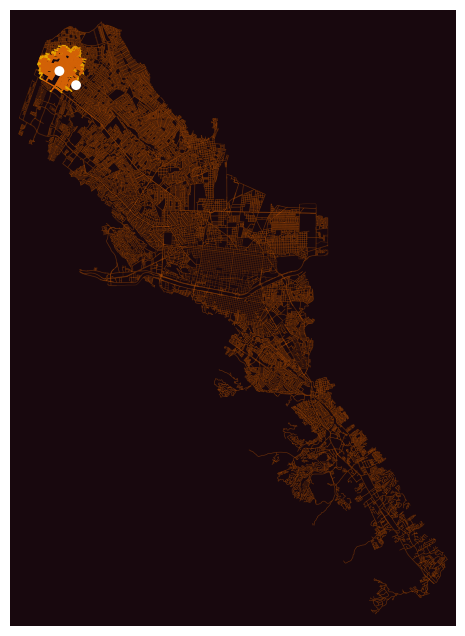

In [182]:
dijkstra(start, end, plot=True)

Distance: 1.6583430000000001
Avg. speed: 39.56521739130435
Total time: 2.514849824175824


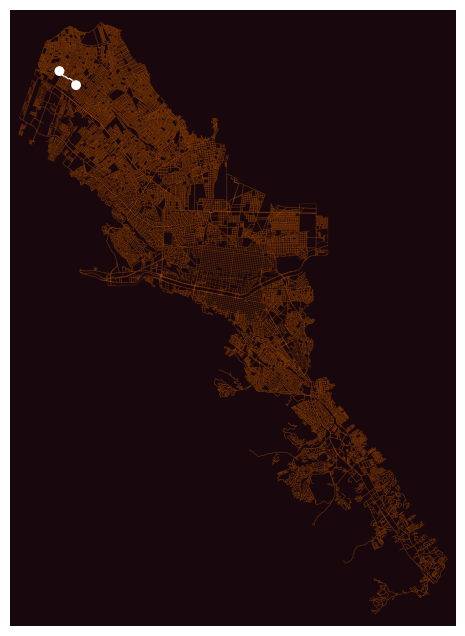

In [183]:
reconstruct_path(start, end, plot=True)

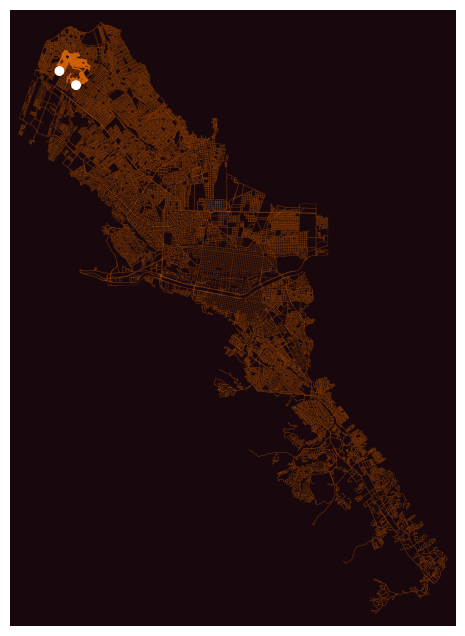

In [184]:
depth_first_search(start, end, plot=True)

Distance: 19.47821100000001
Avg. speed: 40.0
Total time: 29.217316500000013


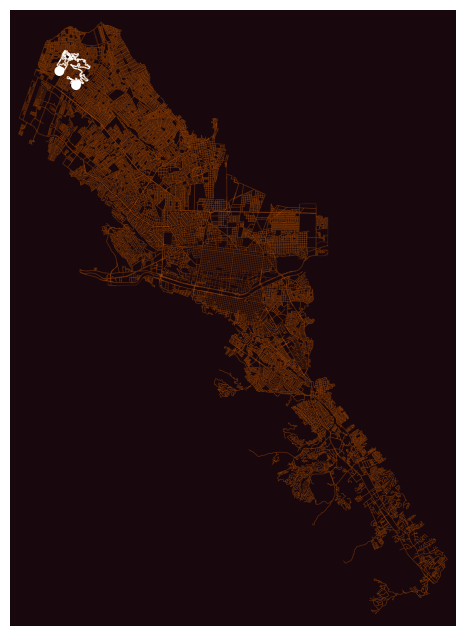

In [185]:
reconstruct_path(start, end, plot=True)

Iterations: 651


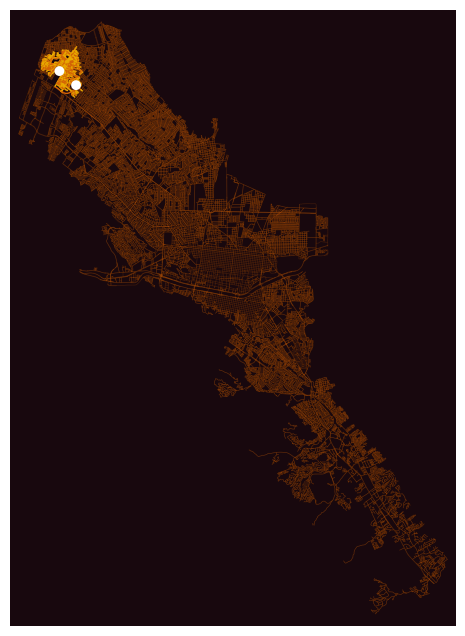

In [186]:
breadth_first_search(start, end, plot=True)

Distance: 1.6640599999999997
Avg. speed: 39.473684210526315
Total time: 2.5293711999999995


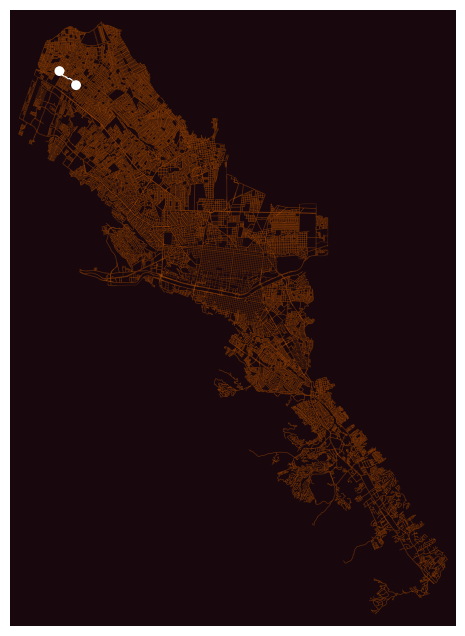

In [187]:
reconstruct_path(start, end, plot=True)

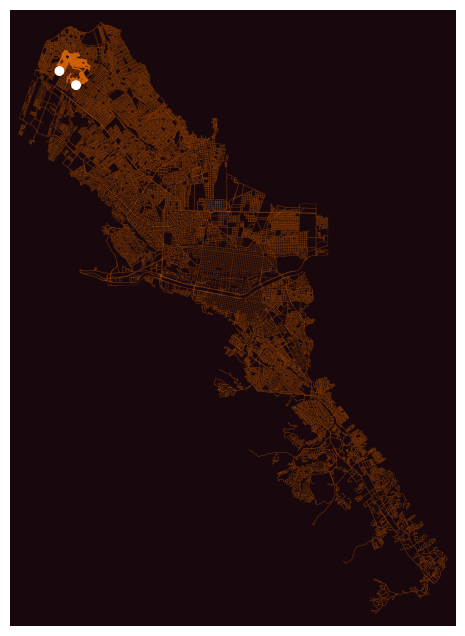

In [188]:
depth_first_limited_search(start, end, 1000, plot=True)

Distance: 19.47821100000001
Avg. speed: 40.0
Total time: 29.217316500000013


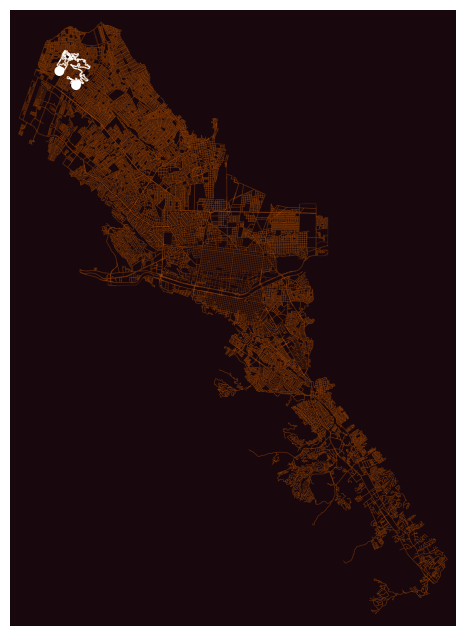

In [189]:
reconstruct_path(start, end, plot=True)

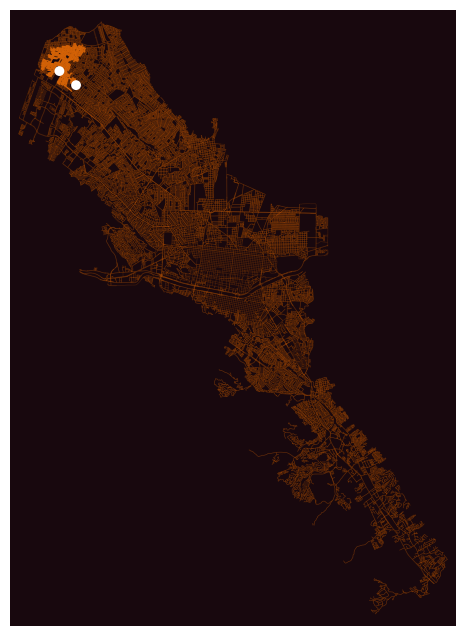

In [190]:
iterative_deepening_dfs(start, end, plot=True)

Distance: 3.3859399999999997
Avg. speed: 40.0
Total time: 5.07891


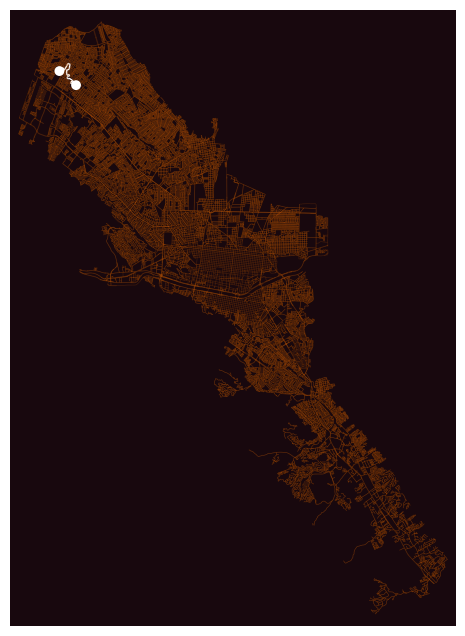

In [191]:
reconstruct_path(start, end, plot=True) 